# Potential Plot
> - Extension following Oleg's discussion on 2020-06-28

Minimization of the following:

$$
\bar{u}_\text{pot} = \frac{U}{E_J} = -\big[ \alpha\cos(\varphi_{02}) + \cos(\varphi_{03}) + \cos(\varphi_{01}) + \\
+ \cos(\varphi_{02} - \varphi_{01} - L) + \cos(\varphi_{02} - \varphi_{03} + R)\big]
$$


In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from time import time

from functions.potential import potential_function

FLUX = float
FLUX_NUMBER = int
cos = np.cos
sin = np.sin
pi = np.pi
plt.style.use('my_official')

# Defining numeric function to mimimize the potential
Optimisation with brute forcing way through the grid - turns out to be exceedingly slow. It is better to use the analytical functions

In [2]:
from scipy import optimize
from pyprind import ProgBar

def minimise_potential_numerical(
        L: FLUX,
        R: FLUX,
        alpha: float,
        progress_bar: ProgBar,
        number_of_phi_points: int=100,
):
    phi_interval = (-pi, pi)
    
    (minimised_phi, min_potential, _, _) = optimize.brute(
        func=potential_function,
        ranges=(phi_interval, phi_interval, phi_interval),
        args = (L, R, alpha),
        full_output=True,
        Ns=number_of_phi_points,
        #finish=optimize.fmin,
        workers=16,
    )

    (phi01, phi02, phi03) = (minimised_phi[0], minimised_phi[1], minimised_phi[2])
    progress_bar.update()
    return (phi01, phi02, phi03, min_potential)

minimise_potential_numerical_vectorised = np.vectorize(
    minimise_potential_numerical,
    excluded={"alpha", "number_of_phi_points", "progress_bar"}
)

# Running the optimisation for range of L-R values

In [4]:
start = time()

NUMBER_OF_PHI_POINTS=21
NROWSCOLS = 51
ALPHA = 1
LOWER = -0.5
UPPER = 1.5

progress_bar = ProgBar(NUMBER_OF_PHI_POINTS * NROWSCOLS, bar_char="█")
grid = np.linspace(LOWER *2*pi, UPPER * 2 * pi, NROWSCOLS)
(grid_x, grid_y) = np.meshgrid(grid, grid)
(phi01_grid, phi02_grid, phi03_grid, potential_grid) = minimise_potential_numerical_vectorised(
    L=grid_x,
    R=grid_y,
    alpha=ALPHA,
    number_of_phi_points=NUMBER_OF_PHI_POINTS,
    progress_bar=progress_bar
)

print(f"Completed in {time() - start:.2f} seconds")

0% [██████████████████████████████] 100% | ETA: 00:00:00
Total time elapsed: 00:03:05


Completed in 450.09 seconds


# Plot
- Usual
- With smoothing

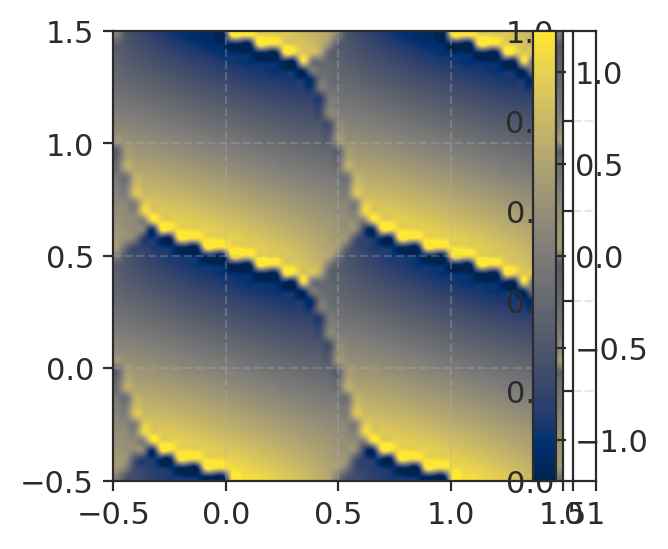

In [9]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(3, 3))
divider = make_axes_locatable(ax)
cbar_axes = divider.append_axes("right", size="5%", pad=0.05)

im = ax.imshow(phi03_grid, 
               extent = [LOWER, UPPER, LOWER, UPPER], 
               origin= 'lower',
              cmap='cividis',
              # cmap='YlGnBu'
              interpolation='spline36')
cbar = fig.colorbar(im, ax=cbar_axes)

[Text(1, 0, '0'),
 Text(1, 0, '0.5'),
 Text(1, 0, '1'),
 Text(1, 0, '1.5'),
 Text(1, 0, '2')]

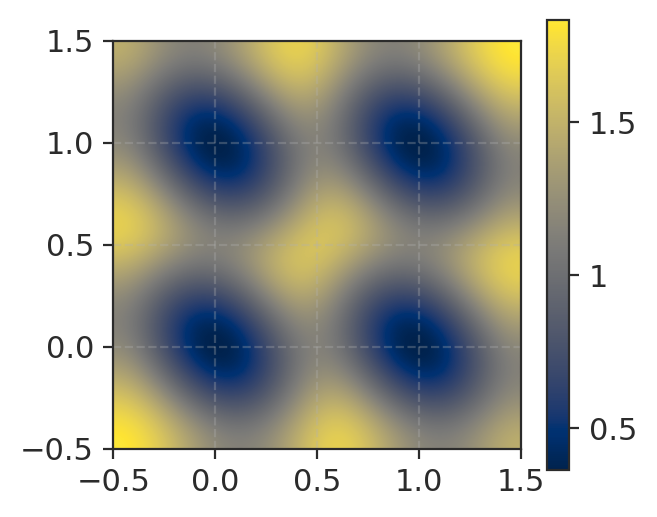

In [7]:
from scipy.ndimage.filters import gaussian_filter

fitlered_potential_grid = gaussian_filter(potential_grid, sigma=4)

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(3, 3))
im = ax.imshow(fitlered_potential_grid, 
               extent = [LOWER, UPPER, LOWER, UPPER], 
               origin= 'lower',
              cmap='cividis',
              # cmap='YlGnBu'
              interpolation='spline36')
cbar = fig.colorbar(im, ticks=[0, 0.5, 1, 1.5, 2])
cbar.ax.set_yticklabels([0, 0.5, 1, 1.5, 2]) 
#contour = ax.contour(grid_x, grid_y, potential_grid, 5, colors='black');
#ax.clabel(contour, inline=True, fontsize=8)

# Defining analytic functions for phi01, phi03 and potential value

$$
\varphi_{01} = \varphi_{02} - \varphi_{01} - L + 2\pi l\\
= \frac{\varphi_{02} - L}{2} + \pi l\\
\varphi_{03} = \frac{\varphi_{02} + R}{2} - \pi r
$$

and a constraints to make sure that they are minimal

$$
\cos(\varphi_{01}) + \cos(\varphi_{02} - \varphi_{01} - L) \ge 0\\
\cos(\varphi_{03}) + \cos(\varphi_{02} - \varphi_{03} + R) \ge 0
$$

In [10]:
from functools import wraps
from itertools import permutations
from typing import Callable
import sys


def cast_to_minus_pi_plus_pi_interval(target_function):

    @wraps(target_function)
    def wrapper(*args, **kwargs):
        return_value = target_function(*args, **kwargs)
        if return_value > pi:
            return return_value - 2 * pi * abs(int(float(return_value + pi) / (2 * pi)))
        elif return_value < -pi:
            return return_value + 2 * pi * abs(int(float(return_value - pi) / (2 * pi)))
        return return_value

    return wrapper


@cast_to_minus_pi_plus_pi_interval
def phi01_eval(
    L: FLUX, R: FLUX, l: FLUX_NUMBER, r: FLUX_NUMBER, alpha: float, phi02: float
):

    return (phi02 - L + 2 * pi * l) / 2


@cast_to_minus_pi_plus_pi_interval
def phi03_eval(
    L: FLUX, R: FLUX, l: FLUX_NUMBER, r: FLUX_NUMBER, alpha: float, phi02: float
):

    return (phi02 + R - 2 * pi * r) / 2


def minimised_potential(
    L: FLUX,
    R: FLUX,
    alpha: float,
    phi02_eval: Callable[[FLUX, FLUX, FLUX_NUMBER, FLUX_NUMBER, float], float],
    tolerance: float
):
    """Minimal potential for plotting
    Supply a custom phi02_eval function to minimize phi02
    """
    (min_l, min_r, min_potential) = (None, None, None)

    # Scan all possibilities of l and r
    for (l, r) in permutations([-3, -2, -1, 0, 1, 2, 3], r=2):
        phi02 = phi02_eval(L, R, l, r, alpha)
        phi01 = phi01_eval(L, R, l, r, alpha, phi02)
        phi03 = phi03_eval(L, R, l, r, alpha, phi02)

        potential = 4 + alpha -(
            alpha * cos(phi02)
            + cos(phi01)
            + cos(phi03)
            + cos(phi02 - phi01 - L)
            + cos(phi02 - phi03 + R)
        )

        if min_potential is None:
            min_potential = potential
            min_l = l
            min_r = r
        elif potential <= min_potential + tolerance:
            # Tolerance is added to combat approximations -
            min_potential = potential
            min_l = l
            min_r = r

    return (phi01, phi02, phi03, min_potential, min_l, min_r)

# Vectorize, allows to pass in arguments as arrays
minimised_potential_vectorized = np.vectorize(
    minimised_potential, excluded={"l", "r", "alpha", "phi02_eval"}
)

# Numerical and approximation functions for phi02
For φ02, we equation is 
$$
\frac{\partial \bar{u}_\text{pot}}{\partial \varphi_{02}} = \alpha\sin(\varphi_{02}) + \sin(\varphi_{02} - \varphi_{01} - L) + \sin(\varphi_{02} - \varphi_{03} + R) = 0
$$

which does not have an analytical solution. The best that can be done is to expand to nth order. Below we define functions to:
- Taylor expand the function
- Find the roots


In [11]:
from functools import reduce
import math

def sin_expansion(x: float, nth_order: int) -> float:
    """Taylor series sin expansion"""
    
    cut_off_iteration = (nth_order + 1) // 2
    
    return reduce(
        lambda cumulative, n: (
            cumulative +
            (-1)**n * x**(2*n+1) / math.factorial(2*n + 1)
        ),
        range(0, cut_off_iteration),
        0
    )

def phi02_partial_derivative_exact(phi02: float, L: FLUX, R:FLUX, l: FLUX_NUMBER, r: FLUX_NUMBER, alpha: float) -> float:
    return (
        alpha * sin(phi02)
        + sin((phi02 - L - 2 * pi * l)/2)
        + sin((phi02 + R + 2 * pi * r)/2)
    )

def phi02_partial_derivative_approximated(phi02: float, L: FLUX, R:FLUX, l: FLUX_NUMBER, r: FLUX_NUMBER, alpha: float, N: int) -> float:
    return (
        alpha * sin_expansion(phi02, N)
        + sin_expansion((phi02 - L - 2 * pi * l)/2, N)
        + sin_expansion((phi02 + R + 2 * pi * r)/2, N)
    )


In [18]:
from scipy.optimize import brentq, ridder, newton
from functools import partial

@cast_to_minus_pi_plus_pi_interval
def phi02_eval_exact(L: FLUX, R: FLUX, l: FLUX_NUMBER, r: FLUX_NUMBER, alpha: float) -> float:
    return newton(
        phi02_partial_derivative_exact,
        x0=0.01,
        args=(L, R, l, r, alpha),
        # tol=0.01,
        maxiter=10000
    )

@cast_to_minus_pi_plus_pi_interval
def phi02_eval_approximated(L: FLUX, R: FLUX, l: FLUX_NUMBER, r: FLUX_NUMBER, alpha: float, N: int) -> float: 
    return newton(
        phi02_partial_derivative_approximated,
        x0=0.01,
        args=(L, R, l, r, alpha, N),
        # tol=0.01,
        maxiter=10000
    )


# Example of how to create for injecting into minimised potential
phi02_eval_approximated_1st_order = partial(phi02_eval_approximated, N=1)
phi02_eval_approximated_3rd_order = partial(phi02_eval_approximated, N=3)


## Tests ##
- Test that sin expansion works
- Proof that the approximation and exact functions converge
- Test that the evaluated root is consistent with analytical first order expansion


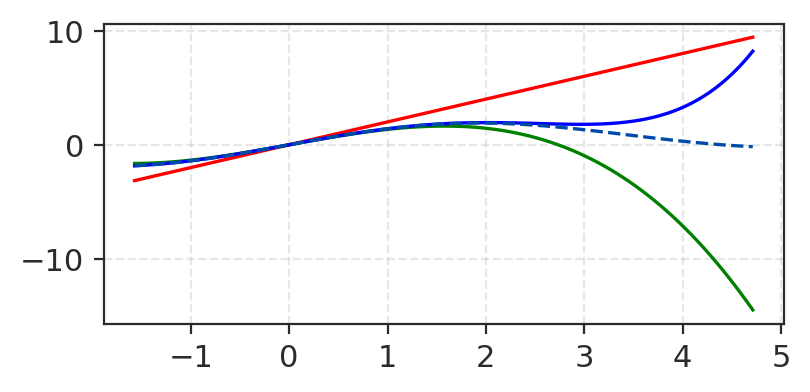

In [19]:
import pytest

# Test that sin expansion works
assert sin_expansion(1.33, 10) == pytest.approx(np.sin(1.33))

# Test that taylor expansion of the equation, approximates the real equation 
flux_list = np.linspace(-0.5*pi,1.5*pi,101)
(L, R) = (-0.6*pi, -0.6*pi)
(l, r) = (0, 0)
alpha = 1

fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4, 2))
ax.plot(flux_list, [phi02_partial_derivative_approximated(x, L, R, l, r, alpha, 1) for x in flux_list],color='red')
ax.plot(flux_list, [phi02_partial_derivative_approximated(x, L, R, l, r, alpha, 3) for x in flux_list],color='green')
ax.plot(flux_list, [phi02_partial_derivative_approximated(x, L, R, l, r, alpha, 5) for x in flux_list],color='blue')
ax.plot(flux_list, [phi02_partial_derivative_exact(x, L, R, l, r, alpha) for x in flux_list], linestyle='--')

# Test that the evaluated root is consistent with analytical first order expansion
(L, R) = (0.6*pi, 0.6*pi)
(l, r) = (0, 0)
alpha = 1.2

assert (L - R + 2 * pi * (l - r)) / (2 * (1 + alpha)) == pytest.approx(phi02_eval_approximated_1st_order(L, R, l, r, alpha), abs=0.3)

# Plotting along the main and perpendicular diagonals
- `L=R` is along main diagonal
- `L+R=const` is along the perpendicular one


Text(0.5, 1.0, 'Min R')

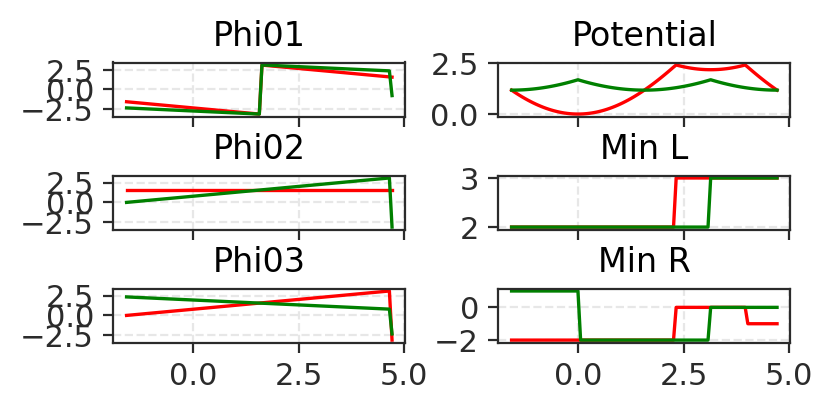

In [22]:
flux_list = np.linspace(-0.5*pi, 1.5*pi, 101)
TOLERANCE = 0.01

potential_minimum_1st_order = list(
    map(lambda x:
        minimised_potential(x, x, 1, partial(phi02_eval_approximated, N=1), tolerance=TOLERANCE),
        flux_list))
potential_minimum_1st_order_perpendicular = list(
    map(lambda x:
        minimised_potential(x, pi - x, 1, partial(phi02_eval_approximated, N=1), tolerance=TOLERANCE),
        flux_list))
#potential_minimum_3rd_order = list(
#    map(lambda x: 
#        minimised_potential(x, x, 1, partial(phi02_eval_approximated, N=3), tolerance=TOLERANCE), 
#        flux_list))

fig, ax = plt.subplots(3, 2, sharex=True, sharey=False, figsize=(4, 2))
fig.tight_layout()
ax[0][0].plot(flux_list, [x[0] for x in potential_minimum_1st_order], color='red')
ax[0][0].plot(flux_list, [x[0] for x in potential_minimum_1st_order_perpendicular], color='green')
ax[0][0].set_title("Phi01", fontsize=12)

ax[1][0].plot(flux_list, [x[1] for x in potential_minimum_1st_order], color='red')
ax[1][0].plot(flux_list, [x[1] for x in potential_minimum_1st_order_perpendicular], color='green')
ax[1][0].set_title("Phi02", fontsize=12)

ax[2][0].plot(flux_list, [x[2] for x in potential_minimum_1st_order], color='red')
ax[2][0].plot(flux_list, [x[2] for x in potential_minimum_1st_order_perpendicular], color='green')
ax[2][0].set_title("Phi03", fontsize=12)

ax[0][1].plot(flux_list, [x[3] for x in potential_minimum_1st_order], color='red')
ax[0][1].plot(flux_list, [x[3] for x in potential_minimum_1st_order_perpendicular], color='green')
ax[0][1].set_title("Potential", fontsize=12)

ax[1][1].plot(flux_list, [x[4] for x in potential_minimum_1st_order], color='red')
ax[1][1].plot(flux_list, [x[4] for x in potential_minimum_1st_order_perpendicular], color='green')

ax[1][1].set_title("Min L", fontsize=12)

ax[2][1].plot(flux_list, [x[5] for x in potential_minimum_1st_order], color='red')
ax[2][1].plot(flux_list, [x[5] for x in potential_minimum_1st_order_perpendicular], color='green')
ax[2][1].set_title("Min R", fontsize=12)

# Plotting full plane

In [23]:
NROWSCOLS = 51
ALPHA = 1
LOWER = -0.5
UPPER = 1.5
TOLERANCE = 0.1

grid = np.linspace(LOWER * 2 * pi, UPPER * 2 * pi, NROWSCOLS)
grid_x, grid_y = np.meshgrid(grid, grid)
(phi01_grid, phi02_grid, phi03_grid, potential_grid, l_grid, r_grid) = minimised_potential_vectorized(
    L=grid_x, R=grid_y,
    alpha=ALPHA,
    phi02_eval=partial(phi02_eval_approximated, N=1),
    tolerance=TOLERANCE
)


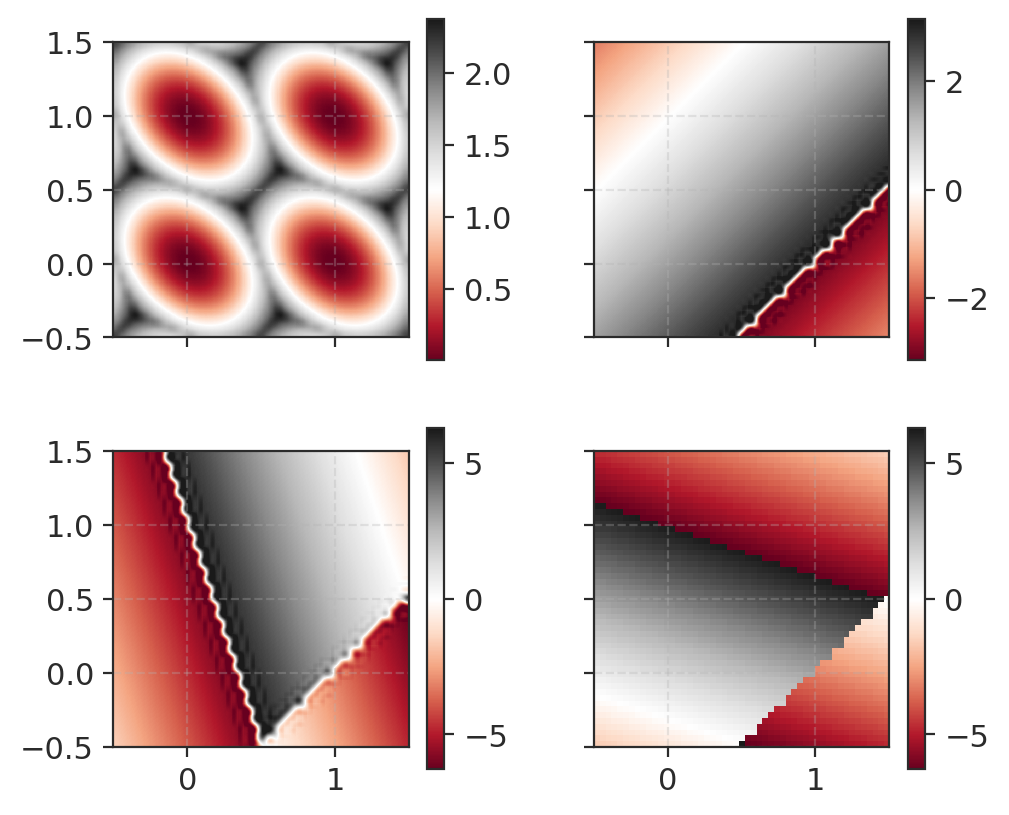

In [24]:
from scipy.ndimage.filters import gaussian_filter

filtered_phi03_grid = gaussian_filter(phi03_grid, sigma=4)
filtered_phi01_grid = gaussian_filter(phi01_grid, sigma=4)
filtered_phi02_grid = gaussian_filter(phi02_grid, sigma=4)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(5, 5))
im0 = ax[0][0].imshow(potential_grid,
               extent = [LOWER, UPPER, LOWER, UPPER],
               origin='lower',
               cmap='RdGy',
               interpolation='bessel')
fig.colorbar(im0, ax=ax[0][0])
im1 = ax[0][1].imshow(phi02_grid,
               extent = [LOWER, UPPER, LOWER, UPPER],
               origin='lower',
               cmap='RdGy', 
               interpolation='bessel')
fig.colorbar(im1, ax=ax[0][1])
im2 = ax[1][0].imshow(phi01_grid + phi01_grid,
               extent = [LOWER, UPPER, LOWER, UPPER],
               origin='lower',
               cmap='RdGy',
               interpolation='bessel')
fig.colorbar(im2, ax=ax[1][0])
im3 = ax[1][1].imshow(phi03_grid + phi03_grid,
               extent = [LOWER, UPPER, LOWER, UPPER],
               origin='lower',
               cmap='RdGy',
               #interpolation='bessel'
                     )
fig.colorbar(im3, ax=ax[1][1])


<IPython.core.display.Javascript object>


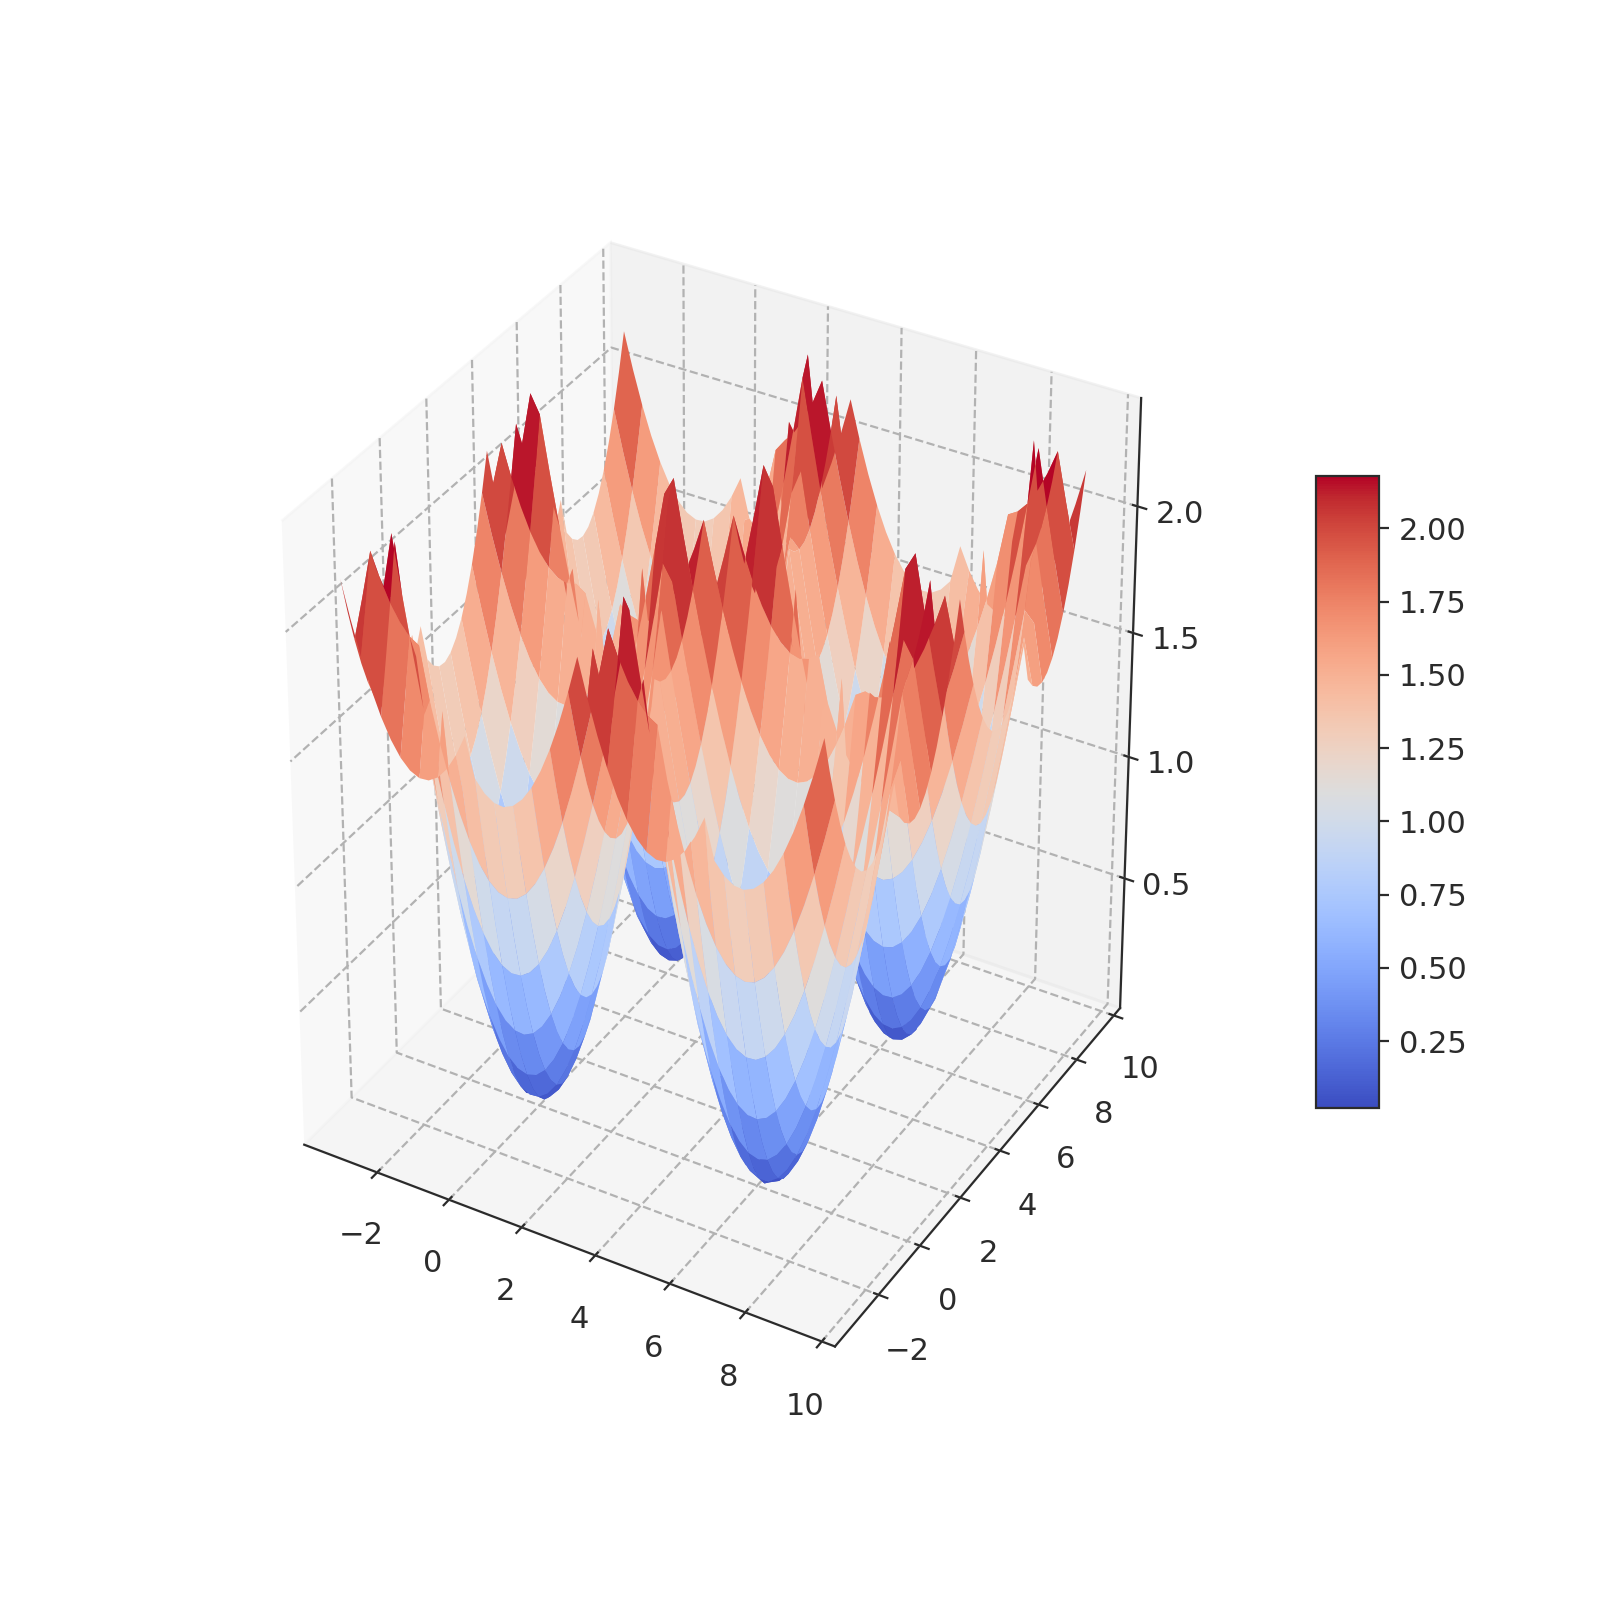

In [26]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(grid_x, grid_y, potential_grid, 
                       cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
fig.colorbar(surf, shrink=0.5, aspect=10)